# Fake news detection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [5]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [6]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
# Check the data
data.head()

,title,text,subject,date,target
0,White House divisions on display with Scaramuc...,WASHINGTON (Reuters) - The rifts inside Presid...,politicsNews,"July 27, 2017",true
1,Democrat Forces Trump’s Own Nominee To MOCK H...,Donald Trump is fuming over the size of his li...,News,"January 24, 2017",fake
2,"Trump, Biden attend same Pennsylvania college ...",(Reuters) - Presidential politics crept into t...,politicsNews,"May 15, 2016",true
3,JUST IN: FORMER NBC NEWS ANCHOR Tom Brokaw Tel...,"This morning, President Trump tweeted a note o...",politics,"Dec 21, 2017",fake
4,Marriott Hotel Shoots Back Response After Musl...,A Muslim activist group has pushed Marriott I...,politics,"Sep 22, 2017",fake


In [9]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,White House divisions on display with Scaramuc...,WASHINGTON (Reuters) - The rifts inside Presid...,politicsNews,true
1,Democrat Forces Trump’s Own Nominee To MOCK H...,Donald Trump is fuming over the size of his li...,News,fake
2,"Trump, Biden attend same Pennsylvania college ...",(Reuters) - Presidential politics crept into t...,politicsNews,true
3,JUST IN: FORMER NBC NEWS ANCHOR Tom Brokaw Tel...,"This morning, President Trump tweeted a note o...",politics,fake
4,Marriott Hotel Shoots Back Response After Musl...,A Muslim activist group has pushed Marriott I...,politics,fake


In [10]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - The rifts inside Presid...,politicsNews,true
1,Donald Trump is fuming over the size of his li...,News,fake
2,(Reuters) - Presidential politics crept into t...,politicsNews,true
3,"This morning, President Trump tweeted a note o...",politics,fake
4,A Muslim activist group has pushed Marriott I...,politics,fake


In [11]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - the rifts inside presid...,politicsNews,true
1,donald trump is fuming over the size of his li...,News,fake
2,(reuters) - presidential politics crept into t...,politicsNews,true
3,"this morning, president trump tweeted a note o...",politics,fake
4,a muslim activist group has pushed marriott i...,politics,fake


In [12]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# Check
data.head()

,text,subject,target
0,seoulunited nations reuters north korea said ...,worldnews,true
1,hillary s lawless antiamerican supporters were...,left-news,fake
2,donald trump is no fan of cnn he has repeatedl...,News,fake
3,paris reuters french president emmanuel macro...,worldnews,true
4,washington reuters republican us senator susa...,politicsNews,true


In [13]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Meme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
data.head()

,text,subject,target
0,washington reuters rifts inside president dona...,politicsNews,true
1,donald trump fuming size little inauguration l...,News,fake
2,reuters presidential politics crept graduation...,politicsNews,true
3,morning president trump tweeted note congratul...,politics,fake
4,muslim activist group pushed marriott internat...,politics,fake


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


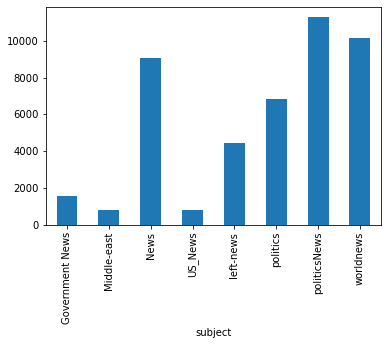

In [15]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


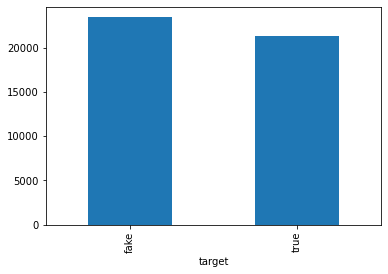

In [16]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

In [17]:
!pip install wordcloud

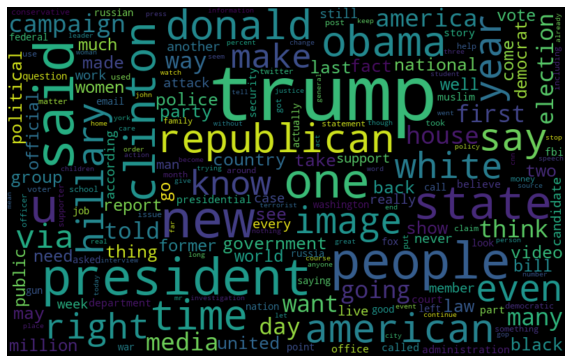

In [18]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

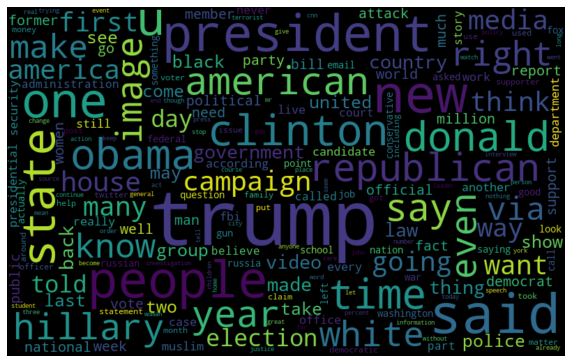

In [19]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

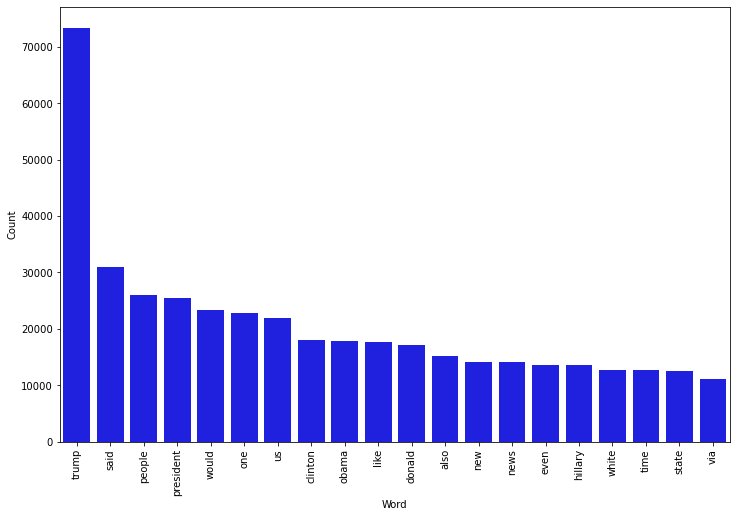

In [21]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

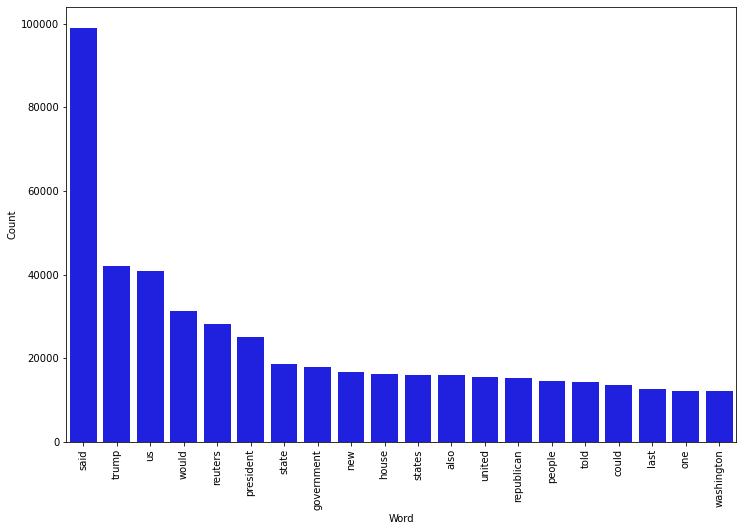

In [22]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling

In [23]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Peparing the data

In [24]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

In [25]:
X_test

22216    washington reuters white house said monday “st...
27917    barcelona reuters spanish authorities sunday p...
25007    matt lauer gave donald trump chance stop actin...
1377     washington reuters environmental protection ag...
32476    bogota reuters bomb attack colombia leftist el...
                               ...                        
42119    washington reuters president donald trump said...
4068     barcelona reuters proindependence parties may ...
22498    comedian andy dick repeatedly slid hands ivank...
14658    cult 45 name given former reality show star do...
15236    hillary pretends care black community cared mu...
Name: text, Length: 8980, dtype: object

### Logistic regression

In [26]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.82%


In [28]:
# save the model to disk
import pickle
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
 
prediction = loaded_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.82%


In [30]:
sample=["paris reuters french president emmanuel"]
prediction = loaded_model.predict(sample)
print(prediction)

['true']


### Decision Tree Classifier

In [32]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.77%


Confusion matrix, without normalization


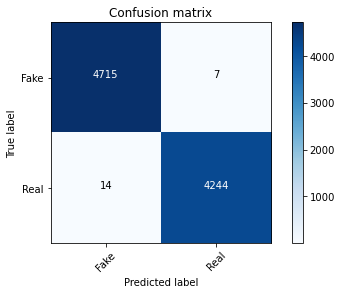

In [33]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

In [34]:
# save the model to disk

filename = 'finalized_model2.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
 
prediction = loaded_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.77%


### Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.14%


In [36]:
# save the model to disk
import pickle
filename = 'finalized_model3.sav'
pickle.dump(model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
 
prediction = loaded_model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.14%


Confusion matrix, without normalization


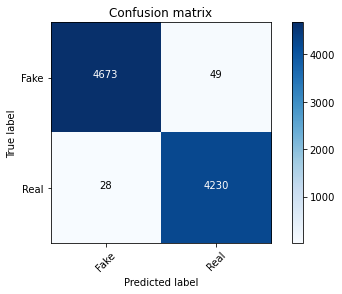

In [37]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])